In [1]:
import torchvision
import torch
from collections import defaultdict
import cv2 as cv
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.autograd import Variable


In [ ]:
device='cuda'

## 1) Loading the Style and Content Images

In [ ]:
content_img=cv.imread(os.path.join(os.getcwd(), '../datasets/content_images/content_test_2.jpg'))
content_img=cv.cvtColor(content_img,cv.COLOR_BGR2RGB)
style_img=cv.imread(os.path.join(os.getcwd(), '../datasets/style_images/van_goh_self_potrait.jpg'))
style_img=cv.cvtColor(style_img,cv.COLOR_BGR2RGB)
img_size=content_img.shape

## 2) Preprocessing the images

In [ ]:
normalize_mean= torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms().mean
normalize_std= torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms().std
# normalize_mean= [123.675, 116.28, 103.53]
# normalize_std= [1,1,1]


In [3]:
transforms=torchvision.transforms.Compose([  torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Resize(content_img.shape[:-1]),
                                        #    torchvision.transforms.Lambda(lambda x: x.mul(255)),
                                           torchvision.transforms.Normalize(normalize_mean,normalize_std)
                                           ])

In [4]:
style_img=transforms(style_img)
style_img.requires_grad_=False

content_img=transforms(content_img)
content_img.requires_grad=False

## 3) Initalizating VGG model for extracting feature Maps.

In [5]:
class vgg19(torch.nn.Module):
    def __init__(self,style_layers,content_layer):
        super().__init__()

        self.style_layers=style_layers
        self.content_layer=content_layer
        self.layers=torch.nn.ModuleDict()
        model=torchvision.models.vgg19(weights="DEFAULT")    
        layer=1
        sub_layer=1
        relu_class_name=type(model.features[1])
        maxpool_class_name=type(model.features[4])
        features=model.features
        for x in features:
            if(isinstance(x,maxpool_class_name)):
                layer+=1
                sub_layer=1
                
            dict_key="conv"+str(layer)+"_"+str(sub_layer)
            if dict_key not in self.layers:
                self.layers[dict_key]=torch.nn.Sequential()
            self.layers[dict_key].add_module(str(x),x)
            
            if(isinstance(x,torch.nn.modules.activation.ReLU)):
                sub_layer+=1

        self.transforms=torchvision.transforms.Compose([torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms()])
    
    def forward(self,img):
        output={"style_feature_map":{}, "content_feature_map":{}}
        res=img
        for layer in self.layers:
            res=self.layers[layer](res)
            
            if layer in self.content_layer:
                output["content_feature_map"][layer]=res
            
            if layer in self.style_layers:
                output["style_feature_map"][layer]=res

            
        return  output
                
            
                                      
            
    

## 4) Style Reconstruction

In [7]:
vgg_model=vgg19(['conv1_2','conv2_2','conv3_4','conv4_4','conv5_4'],'conv4_4')
for param in vgg_model.parameters():
    param.requires_grad=False

In [8]:
noisy_img=torch.from_numpy(np.random.normal(0, 1, content_img.shape)).float().to(device)
# noisy_img=noisy_img.permute(2,0,1)
noisy_img=Variable(noisy_img,requires_grad=True)

In [10]:
def get_gram_matrix(feature_maps):
   c,h,w = feature_maps.shape
   fm=feature_maps.reshape(c,h*w)
   return torch.mm(fm, torch.transpose(fm,0,1))

In [29]:
def train(model, style_img, noisy_img,epoch):
    style_output=model(style_img)  
    optimizer=torch.optim.Adam((noisy_img,), lr=0.01)
    # optimizer=torch.optim.LBFGS((noisy_img,), lr=0.1)
    print("Getting Feature Maps")
    for i in range(epoch):
        noisy_img_output=model(noisy_img)
        style_img_output= model(style_img)
        
        noisy_gm={}
        style_gm={}
        loss=0
        for x in noisy_img_output['style_feature_map']:
            noisy_gm[x]=get_gram_matrix(noisy_img_output['style_feature_map'][x]) 
        
        for y in style_img_output['style_feature_map']:
            style_gm[y]=get_gram_matrix(style_img_output['style_feature_map'][y])
        
        loss=0
        for x in noisy_gm:
            c,h,w=noisy_img_output['style_feature_map'][x].shape
            layer_loss=(1/20) * torch.sum(((noisy_gm[x] - style_gm[x])/(c*h*w))**2)
            loss+=layer_loss
        total_var_loss=torch.sqrt((torch.nn.MSELoss()(noisy_img[:,:,:-1], noisy_img[:,:,1:]) + torch.nn.MSELoss()(noisy_img[:,:-1,:], noisy_img[:,1:,:])))
        loss+=0.06*total_var_loss
        loss.backward()
        optimizer.step()
        print(noisy_img.grad.shape)
        optimizer.zero_grad()
        print("Epoch: ",i, " Loss: ",loss)


In [30]:
def train_lbfgs(model, style_img, noisy_img,epoch):
    # optimizer=torch.optim.Adam((noisy_img,), lr=0.01)
    optimizer=torch.optim.LBFGS((noisy_img,), lr=0.9, tolerance_grad=1e-20)
    log_loss=[0]
    def closure():
        optimizer.zero_grad()
        noisy_img_output=model(noisy_img)
        style_img_output= model(style_img)
        
        noisy_gm={}
        style_gm={}
        loss=0
        for x in noisy_img_output['style_feature_map']:
            noisy_gm[x]=get_gram_matrix(noisy_img_output['style_feature_map'][x]) 
        
        for y in style_img_output['style_feature_map']:
            style_gm[y]=get_gram_matrix(style_img_output['style_feature_map'][y])
        
        loss=0
        for x in noisy_gm:
            c,h,w=noisy_img_output['style_feature_map'][x].shape
            layer_loss=(1/20) * torch.sum(((noisy_gm[x] - style_gm[x])/(c*h*w))**2)
            loss+=layer_loss
        
        log_loss[0]=loss.item()
        total_var_loss=torch.sqrt((torch.nn.MSELoss()(noisy_img[:,:,:-1], noisy_img[:,:,1:]) + torch.nn.MSELoss()(noisy_img[:,:-1,:], noisy_img[:,1:,:])))
        loss+=0.01*total_var_loss
        loss.backward()
        return loss
        
    for i in range(epoch):
        optimizer.step(closure)
        print("Epoch: ",i, " Loss: ",log_loss[0])
        print(noisy_img.grad.max())
    

In [31]:
vgg_model.to(device)
style_img=style_img.to(device)

In [32]:
train_lbfgs(vgg_model, style_img, noisy_img,3000)

KeyboardInterrupt: 

In [16]:
noisy_img = noisy_img * torch.tensor(normalize_std).view(3, 1, 1) + + torch.tensor(normalize_mean).view(3, 1, 1)
noisy_img = torch.clamp(noisy_img, 0, 255)
torchvision.transforms.ToPILImage()(noisy_img.byte())

In [109]:
cv.imwrite(os.path.join(os.getcwd(), '../datasets/style_images/test_1.jpg'), noisy_img.detach().cpu().permute(1,2,0).numpy())

True

## 5) Optimization for Neural Style Transfer

In [11]:
def train_neural_style_transfer(model, style_img, content_img, noisy_img,epoch):
    optimizer=torch.optim.Adam((noisy_img,), lr=0.1)
    log_loss=[0,0,0]     
    for i in range(epoch):
        optimizer.zero_grad()
        noisy_img_output=model(noisy_img)
        style_img_output= model(style_img)
        content_img_output=model(content_img)
        
        c,h,w=noisy_img_output['style_feature_map']['conv4_4'].shape
        noisy_fm=noisy_img_output['style_feature_map']['conv4_4'].reshape(c,h*w)
        content_fm=content_img_output['style_feature_map']['conv4_4'].reshape(c,h*w)
        
        content_loss=torch.nn.MSELoss()(noisy_fm,content_fm)
        
        noisy_gm={}
        style_gm={}
        style_loss=0
        for x in noisy_img_output['style_feature_map']:
            noisy_gm[x]=get_gram_matrix(noisy_img_output['style_feature_map'][x]) 
        
        for y in style_img_output['style_feature_map']:
            style_gm[y]=get_gram_matrix(style_img_output['style_feature_map'][y])
        
        loss=0
        for x in noisy_gm:
            c,h,w=noisy_img_output['style_feature_map'][x].shape
            layer_loss=(1/20) * torch.sum(((noisy_gm[x] - style_gm[x])/(c*h*w))**2)
            style_loss+=layer_loss
        
        loss= 1e2*style_loss
        log_loss[0]=loss.item()
        log_loss[1]=style_loss.item()
        log_loss[2]=content_loss.item()

        total_var_loss=torch.sqrt((torch.nn.MSELoss()(noisy_img[:,:,:-1], noisy_img[:,:,1:]) + torch.nn.MSELoss()(noisy_img[:,:-1,:], noisy_img[:,1:,:])))
        loss+=0.1*total_var_loss
        loss.backward()
        optimizer.step()
        print("Epoch: ",i, " Loss: ",log_loss[0], ' style_loss: ', log_loss[1], ' content_loss: ',log_loss[2])

In [12]:
def train_neural_style_transfer_LBFGS(model, style_img, content_img, noisy_img,epoch):
    optimizer=torch.optim.LBFGS((noisy_img,), lr=0.9)
    log_loss=[0,0,0]
    def closure():
        optimizer.zero_grad()
        noisy_img_output=model(noisy_img)
        style_img_output= model(style_img)
        content_img_output=model(content_img)
        
        c,h,w=noisy_img_output['style_feature_map']['conv3_1'].shape
        noisy_fm=noisy_img_output['style_feature_map']['conv3_1'].reshape(c,h*w)
        content_fm=content_img_output['style_feature_map']['conv3_1'].reshape(c,h*w)
        
        content_loss=torch.nn.MSELoss()(noisy_fm,content_fm)
        
        noisy_gm={}
        style_gm={}
        style_loss=0
        for x in noisy_img_output['style_feature_map']:
            noisy_gm[x]=get_gram_matrix(noisy_img_output['style_feature_map'][x]) 
        
        for y in style_img_output['style_feature_map']:
            style_gm[y]=get_gram_matrix(style_img_output['style_feature_map'][y])
        
        loss=0
        for x in noisy_gm:
            c,h,w=noisy_img_output['style_feature_map'][x].shape
            layer_loss=(1/20) * torch.sum(((noisy_gm[x] - style_gm[x])/(c*h*w))**2)
            style_loss+=layer_loss
        
        loss=0*content_loss + 1e10*style_loss
        log_loss[0]=loss.item()
        log_loss[1]=style_loss.item()
        log_loss[2]=content_loss.item()

        total_var_loss=torch.sqrt((torch.nn.MSELoss()(noisy_img[:,:,:-1], noisy_img[:,:,1:]) + torch.nn.MSELoss()(noisy_img[:,:-1,:], noisy_img[:,1:,:])))
        loss+=1e3*total_var_loss
        
        loss.backward()
        return loss
        
    for i in range(epoch):
        optimizer.step(closure)
        print("Epoch: ",i, " Loss: ",log_loss[0], ' style_loss: ', log_loss[1], ' content_loss: ',log_loss[2])

In [13]:
vgg_model=vgg19(['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1'],'conv4_1')
for param in vgg_model.parameters():
    param.requires_grad=False

In [14]:
device='cuda'
content_img=cv.imread(os.path.join(os.getcwd(), '../datasets/content_images/rice_lake.JPG'))
content_img=cv.cvtColor(content_img,cv.COLOR_BGR2RGB)
style_img=cv.imread(os.path.join(os.getcwd(), '../datasets/style_images/Starry_Night.jpg'))
style_img=cv.cvtColor(style_img,cv.COLOR_BGR2RGB)
img_size=content_img.shape
normalize_mean= torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms().mean
normalize_std= torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms().std
style_img=transforms(style_img)
style_img.requires_grad_=False

content_img=transforms(content_img)
content_img.requires_grad=False

# noisy_img=torch.from_numpy(np.random.normal(0, 1, content_img.shape)).float().to(device)
# noisy_img=noisy_img.permute(2,0,1)
noisy_img=Variable(content_img.clone().to(device),requires_grad=True)
vgg_model.to(device)
style_img=style_img.to(device)
content_img=content_img.to(device)

In [15]:
train_neural_style_transfer_LBFGS(vgg_model, style_img,content_img, noisy_img, 1000)

Epoch:  0  Loss:  209078480.0  style_loss:  0.020907847210764885  content_loss:  6.722752094268799
Epoch:  1  Loss:  69252768.0  style_loss:  0.006925276480615139  content_loss:  7.821727752685547
Epoch:  2  Loss:  39729364.0  style_loss:  0.003972936421632767  content_loss:  8.158597946166992
Epoch:  3  Loss:  26519678.0  style_loss:  0.0026519678067415953  content_loss:  8.551081657409668
Epoch:  4  Loss:  19479580.0  style_loss:  0.0019479580223560333  content_loss:  8.761896133422852
Epoch:  5  Loss:  15626049.0  style_loss:  0.0015626049134880304  content_loss:  8.932476997375488
Epoch:  6  Loss:  12886802.0  style_loss:  0.001288680243305862  content_loss:  9.08239459991455
Epoch:  7  Loss:  10989800.0  style_loss:  0.001098979962989688  content_loss:  9.204817771911621
Epoch:  8  Loss:  9490910.0  style_loss:  0.0009490910451859236  content_loss:  9.309134483337402
Epoch:  9  Loss:  8376266.0  style_loss:  0.0008376265759579837  content_loss:  9.395136833190918
Epoch:  10  Loss:

KeyboardInterrupt: 

In [19]:
noisy_img=noisy_img.to('cuda')

In [16]:
noisy_img=noisy_img.to('cpu')
noisy_img = noisy_img*torch.tensor(normalize_std).view(3, 1, 1) + torch.tensor(normalize_mean).view(3, 1, 1)
noisy_img = torch.clamp(noisy_img, 0, 1)

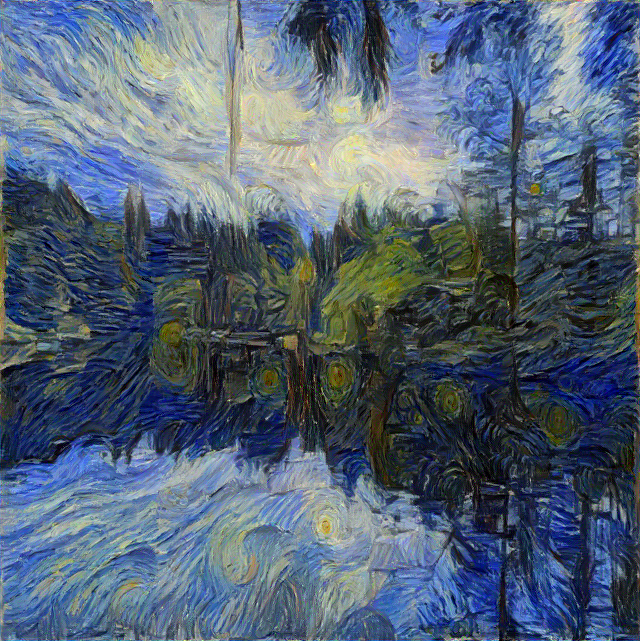

In [17]:
torchvision.transforms.ToPILImage()(noisy_img)